In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras import Model, Input
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import zipfile
import matplotlib.pyplot as plt

In [2]:
dataset_zip = "shoes.zip"
if not os.path.exists("shoes"):
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall("shoes")

train_dir = "shoes/train"
test_dir = "shoes/test"

In [5]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 300, 300

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images from directories
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='sparse'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='sparse'
)

# Base model: DenseNet121
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="input-layer")
X = base_model(inputs, training=False)
X = GlobalAveragePooling2D(name="global_average_pooling_layer")(X)
X = Dropout(0.5)(X)
outputs = Dense(3, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.01))(X)

fm = Model(inputs, outputs)

# Compile the model
fm.compile(optimizer=Adam(learning_rate=0.0001),
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
check_point = ModelCheckpoint(filepath='best_weight.keras', monitor='val_loss', save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

callbacks = [early_stop, check_point, reduce_lr]

# Initial Training
fm_history = fm.fit(
    train_data,
    epochs=10,  # Start with fewer epochs
    validation_data=test_data,
    callbacks=callbacks,
    shuffle=True
)

# Fine-Tuning Step: Unfreeze the base model
base_model.trainable = True

# Compile the model again with a lower learning rate
fm.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

# Fine-Tuning Training
fm_finetune_history = fm.fit(
    train_data,
    epochs=20,  # Fine-tuning for a smaller number of epochs
    validation_data=test_data,
    callbacks=callbacks,
    shuffle=True
)


Found 711 images belonging to 3 classes.
Found 114 images belonging to 3 classes.
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.3004 - loss: 1.6419 - val_accuracy: 0.2982 - val_loss: 1.2604 - learning_rate: 1.0000e-04
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 554ms/step - accuracy: 0.3455 - loss: 1.5271 - val_accuracy: 0.3684 - val_loss: 1.2291 - learning_rate: 1.0000e-04
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 562ms/step - accuracy: 0.3741 - loss: 1.4670 - val_accuracy: 0.3772 - val_loss: 1.2091 - learning_rate: 1.0000e-04
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 529ms/step - accuracy: 0.3171 - loss: 1.5113 - val_accuracy: 0.4035 - val_loss: 1.1914 - learning_rate: 1.0000e-04
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 579ms/step - accuracy: 0.3559 - loss: 1.4718 - val_accuracy: 0.4035 - val_loss: 1.1742 - learning_rate: 1.0000e-04
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 563ms/step - accuracy: 0.3185 - loss: 1.5170 - val_accuracy: 0.4386 - val_loss: 1.1520 - learn

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9104 - loss: 0.2779
Test accuracy: 90.35%


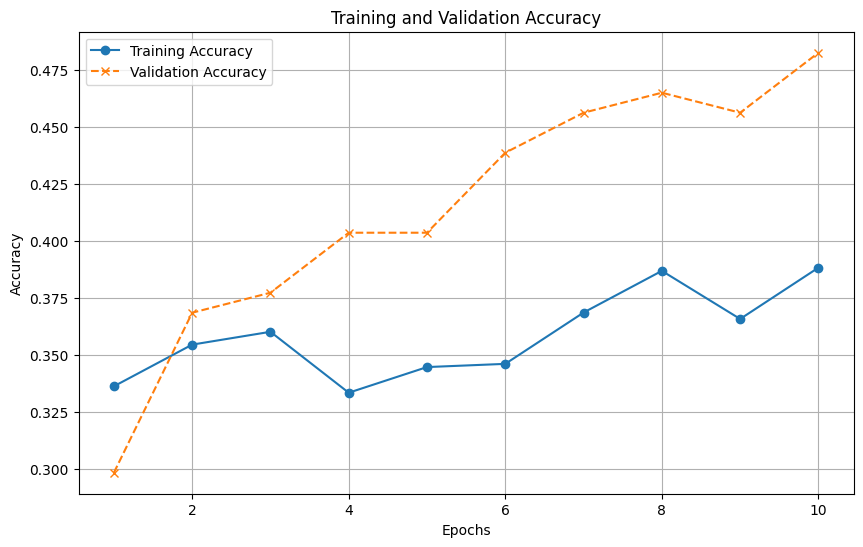

In [6]:
test_loss, test_accuracy = fm.evaluate(test_data)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

acc = fm_history.history['accuracy']
val_acc = fm_history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plot accuracy and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='x', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()